<a href="https://colab.research.google.com/github/ZPavlo/ML_projects/blob/master/object_detecion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH = "/content/gdrive/My Drive"

# Dataset review. Create augmentation 

In [0]:
# Label map
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

# Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [0]:
import os 
import cv2
import numpy as np
import torch
from torchvision.datasets.voc import VOCDetection
import torchvision.transforms as transforms
import torchvision.transforms.functional as func

class MyVOCDetection(VOCDetection):

    def __init__(self, root, image_set, download=False, transforms=None):
      super(MyVOCDetection, self).__init__(root, image_set=image_set, download=download)
      self.dim = (300, 300)
      self.my_transforms = transforms

    def __getitem__(self, index):
      img, target = super().__getitem__(index)

      annotation = target["annotation"]
      boxes_dict = annotation["object"]

      if isinstance(boxes_dict, dict):
        boxes_dict = [boxes_dict]
      size = annotation["size"]
      size = (int(size["depth"]), int(size["height"]), int(size["width"]))
      
      boxes = []
      labels = []
      difficult = []
      for box in boxes_dict:
          boxes.append([float(box["bndbox"]["xmin"]), float(box["bndbox"]["ymin"]),
                        float(box["bndbox"]["xmax"]), float(box["bndbox"]["ymax"])])
          labels.append(label_map[box["name"]])
          difficult.append(int(box["difficult"]))

      boxes = torch.FloatTensor(boxes)

      labels = torch.LongTensor(labels)
      difficult = torch.LongTensor(difficult)
      
      return (img, 
              size, 
              boxes, 
              labels,
              difficult
              )

ROOT_PATH = os.path.join(PATH, "datasets")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

train_dataset = MyVOCDetection(ROOT_PATH, image_set="train", download=False)
val_dataset = MyVOCDetection(ROOT_PATH, image_set="val", download=False)

In [0]:
BATCH_SIZE = 8

In [0]:
from torch.utils.data import DataLoader

def my_collate_fn(samples):

    images = []
    sizes = []
    boxes_batch = []
    labels_batch = []
    diffs_batch = []

    for (img, size, boxes, lab, dif) in samples:
        
        images.append(img)
        boxes_batch.append(boxes)
        sizes.append(size)
        labels_batch.append(lab)
        diffs_batch.append(dif)

    return {"img": images,
            "boxes": boxes_batch,
            "size": sizes,
            "labels": labels_batch,
            "difficult": diffs_batch
            }

train_load = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                        num_workers=0, pin_memory=True, 
                        collate_fn=my_collate_fn)
val_load = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        num_workers=0, pin_memory=True)

In [0]:
batch = next(iter(train_load))


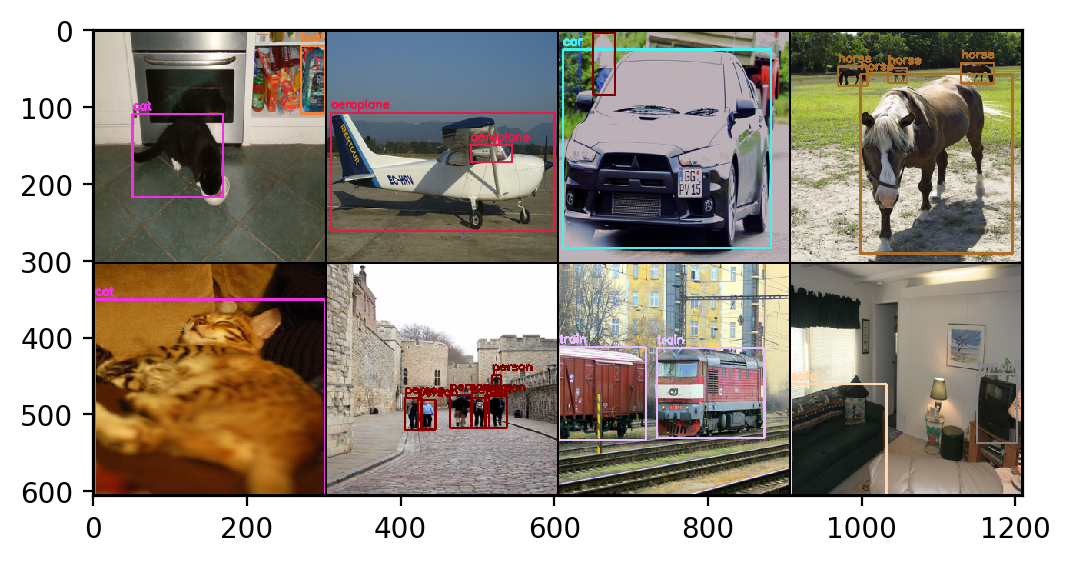

In [8]:
import torchvision.utils as utils
import torch
import matplotlib.pyplot as plt

def draph_boxes(image, objs, labels):
  
    image = np.array(image)

    for (box, l) in zip(objs, labels):
        l = int(l)
        name = rev_label_map[l]
        color = label_color_map[name].lstrip('#')
        color = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
        image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.putText(image, name, (int(box[0]), int(box[1]) - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return torch.from_numpy(np.transpose(image, (2, 0, 1)))

new_imgs = []
for i, img in enumerate(batch["img"]):
    new_imgs.append(draph_boxes(img, batch["boxes"][i], batch["labels"][i]))

grid = utils.make_grid(new_imgs, 4, padding=2)
ngrid = grid.numpy()

plt.figure(dpi=200)
plt.imshow(np.transpose(ngrid, (1, 2, 0)))

In [0]:
def flip(image, boxes):

    # Flip image
    # image = func.to_pil_image(image)
    new_image = func.hflip(image.copy())

    # Flip boxes
    new_boxes = boxes.clone()
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

In [0]:
img = batch["img"][0]
boxes = batch["boxes"][0]
labels = batch["labels"][0]
difficult = batch["difficult"][0]
size = batch["size"][0]

In [0]:
def draph_img(img, boxes, labels):
    draw_img = draph_boxes(img, boxes, labels)
    plt.figure(dpi=150)
    plt.imshow(np.transpose(draw_img.numpy(), (1, 2, 0)))

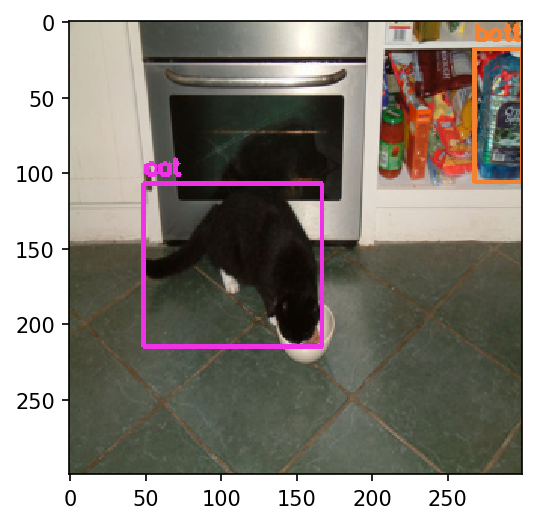

In [12]:
draph_img(img, boxes, labels)

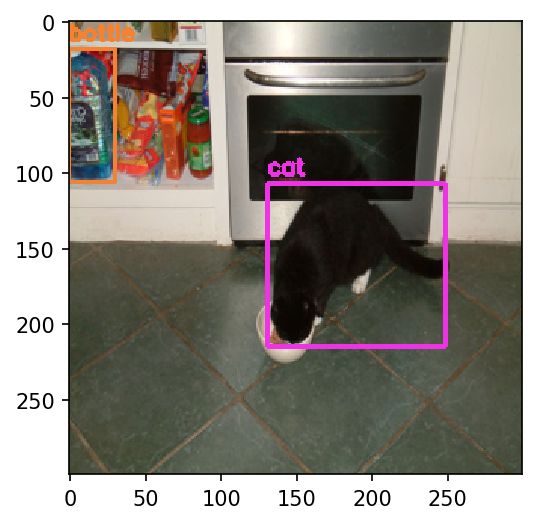

In [13]:
img_flip, boxes_flip = flip(img, boxes)

draph_img(img_flip, boxes_flip, labels)

In [0]:
import random

def photometric_distort(image):
  
    new_image = image

    distortions = [func.adjust_brightness,
                   func.adjust_contrast,
                   func.adjust_saturation,
                   func.adjust_hue]

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is 'adjust_hue':                
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:              
                adjust_factor = random.uniform(0.5, 1.5)
            
            new_image = d(new_image, adjust_factor)

    return new_image

<class 'PIL.Image.Image'>


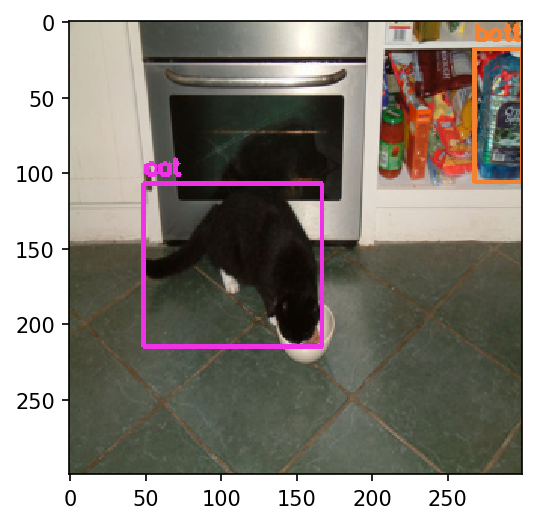

In [20]:
img_dist = photometric_distort(img)
print(type(img_dist))
draph_img(img_dist, boxes, labels)

In [16]:
torch.from_numpy(np.array(img)).shape

torch.Size([300, 300, 3])

In [0]:
def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def random_crop(image, boxes, labels, difficulties):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """

    boxes = boxes.clone()
    labels = labels.clone()
    difficulties = difficulties.clone()

    original_h = image.shape[1]
    original_w = image.shape[2]
  
    while True:
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels, difficulties

        max_trials = 50
        for _ in range(max_trials):
          
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0), boxes) 
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image

            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]
            new_difficulties = difficulties[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels, new_difficulties

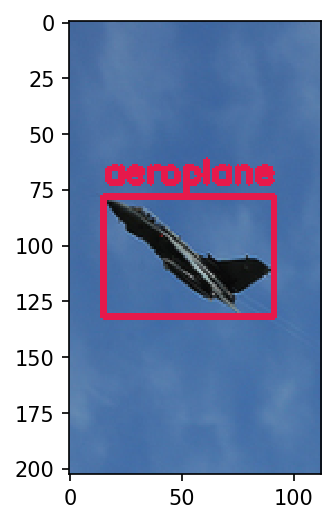

In [95]:
img_crop = func.to_tensor(img)
img_crop, boxes_crop, labels_crop, difficult_crop = random_crop(img_crop, boxes, labels, difficult)
img_crop = func.to_pil_image(img_crop)

draph_img(img_crop, boxes_crop, labels_crop)

In [0]:
def transform(image, boxes, labels, difficulties, split):

    assert split in {'TRAIN', 'TEST'}

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    DIM = (300, 300)

    new_image = image
    new_boxes = boxes.clone()
    new_labels = labels.clone()
    new_difficulties = difficulties.clone()

    if split == 'TRAIN':
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = func.to_tensor(new_image)

        new_image, new_boxes, new_labels, new_difficulties = random_crop(new_image, new_boxes, new_labels,
                                                                         new_difficulties)

        # Convert Torch tensor to PIL image
        new_image = func.to_pil_image(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    w, h = new_image.size
    new_image = func.resize(new_image, DIM)

    new_boxes[:, 0] = new_boxes[:, 0] * (DIM[0] / float(w))
    new_boxes[:, 1] = new_boxes[:, 1] * (DIM[1] / float(h))
    new_boxes[:, 2] = new_boxes[:, 2] * (DIM[0] / float(w))
    new_boxes[:, 3] = new_boxes[:, 3] * (DIM[1] / float(h))

    new_image = func.to_tensor(new_image)
    # new_image = func.normalize(new_image, mean=MEAN, std=STD)

    return new_image, new_boxes, new_labels, new_difficulties

torch.Size([3, 300, 300])
torch.Size([1, 4])
torch.Size([1])
torch.Size([1])


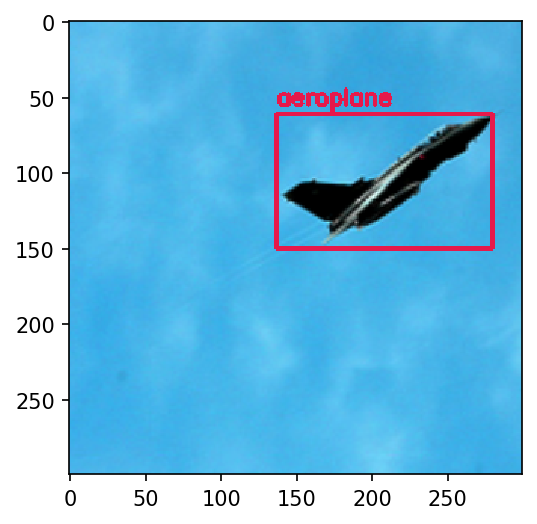

In [110]:
new_image, new_boxes, new_labels, new_difficulties = transform(img, boxes, labels, difficult, "TRAIN")

print(new_image.shape)
print(new_boxes.shape)
print(new_labels.shape)
print(new_difficulties.shape)

d_img = func.to_pil_image(new_image)

draph_img(d_img, new_boxes, new_labels)